<a href="https://colab.research.google.com/github/christinabrnn/Python-Study/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Experimentation and Causal Methods

## Assignment 2: Rocket Fuel

### Due Date: 8am, February 6th, 2025

Jeonghee (Christina) Son


__Instructions:__

Please read the case about RocketFuel from the HBS Case Pack.
For the assignment you need to read the Rocketfuel case, but answer the questions in the assignment. You can ignore the questions on the HBS website


__Important:__

- Remember to write your name in the above markdown cell.

- Remember to write out your answers in words, don't just output Python statistics.
  - EX: Rather then outputting just `10000.0`, say "TaskaBella made $10,000.00 profit from the campaign."

- Before you submit the notebook, please make sure that the text is readable and does not spill over the right side of the screen. To prevent this from happening, make sure to write your verbal answer in the markdown blocks.
  
- The definitions for the columns in the data are in case! Please read them carefully.


In [1]:
%%capture
!pip install pingouin # install the package used for statistical analyses

In [2]:
# import modules and functions
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
pg.options['round.column.CI95%'] = 6

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
# read data (change the path)

ads_data = pd.read_csv('/content/drive/My Drive/rocketfuel_data.csv')
ads_data

,user_id,test,converted,tot_impr,mode_impr_day,mode_impr_hour
0,1069124,1,0,130,1,20
1,1119715,1,0,93,2,22
2,1144181,1,0,21,2,18
3,1435133,1,0,355,2,10
4,1015700,1,0,276,5,14
...,...,...,...,...,...,...
588106,1496403,1,0,24,2,19
588107,1496404,1,0,199,6,19
588108,1496405,1,0,211,6,15
588109,1496406,1,0,98,5,19


### 1. ATE and statistical significance.
#### 1.a What is the $\widehat{ATE}$ of the ads on purchases (conversions)? What does the number mean in words?


In [32]:
ate = ads_data.loc[ads_data['test'] == 1, 'converted'].mean() - ads_data.loc[ads_data['test'] == 0, 'converted'].mean()
print(f"The ATE score is {round(ate * 100, 2)}% and since it is significantly different from 0, we reject the null hypothesis.")

The ATE score is 0.77% and since it is significantly different from 0, we reject the null hypothesis.


The advertising campaign increases the conversion rate by about 0.77 percentage points.

#### 1.b Did the campaign cause more purchases? Is this difference statistically significant?
Hint: Use the pg.ttest function.

In [58]:
## 여기 다시 보기
alpha = .05

treated_sample = ads_data.loc[ads_data['test'] == 1, 'converted']
control_sample = ads_data.loc[ads_data['test'] == 0, 'converted']

t_test = pg.ttest(treated_sample, control_sample,
                  paired=False,
                  alternative='two-sided')

print(f"Yes, the campaign caused more purchases, as evidenced by the statistically significant difference between the treatment and control groups.")
print(f"The p-value was much less than 0.05, and since the confidence interval does not include zero and the power of the test is very high, the difference is statistically significant.")
t_test

Yes, the campaign caused more purchases, as evidenced by the statistically significant difference between the treatment and control groups.
The p-value was much less than 0.05, and since the confidence interval does not include zero and the power of the test is very high, the difference is statistically significant.


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,8.65791,26385.467637,two-sided,5.074303e-18,"[0.005951, 0.009434]",0.049048,1.409e+14,1.0


### 2. Was the campaign profitable?
#### 2.a How much more profit did TaskaBella make **per person** by showing ads (excluding advertising costs)?
Hint: the profit per conversion is given on page 2 of the case.

In [34]:
profit_per_conversion = 40
profit_per_person = profit_per_conversion * ate

print(f"TaskaBella made {round(profit_per_person, 2)} more profit per person by showing ads.")

TaskaBella made 0.31 more profit per person by showing ads.


#### 2.b What was the cost of the campaign per person (including the control group)?  
Hint: The cost per thousand impressions is $9

In [35]:
cpm = 9
total_impr = ads_data['tot_impr'].sum()
total_campaign_cost = total_impr / 1000 * cpm
total_cost_per_person = total_campaign_cost / len(ads_data)

print(f"The cost of the campaign per person was {round(total_cost_per_person, 2)}.")

The cost of the campaign per person was 0.22.


#### 2.c Calculate the ROI of the campaign (including the control group). Was the campaign profitable?  
The ROI is calculated by
$$\text{ROI} = \frac{\text{Effect on Profits per Person in Campaign} - \text{Cost of Ads per Person in Campaign}}{\text{Cost of Ads per Person in Campaign}}$$

In [36]:
roi = (profit_per_person - total_cost_per_person) / total_cost_per_person
print(f"The ROI of the campaign is {round(roi * 100, 2)}%.")

The ROI of the campaign is 37.74%.


#### 2.d What was the opportunity cost of including a control group --- how much more could TaskaBella have made by not having a control group at all?
Hint: The opportunity cost is the profits that TaskaBella missed out by having a control group.

In [37]:
control_group_size = len(ads_data[ads_data['test'] == 0])
opportunity_cost = ate * profit_per_conversion * control_group_size
print(f"The opportunity cost of including a control group is ${round(opportunity_cost, 2)}.")

The opportunity cost of including a control group is $7238.93.


### 3. Did the number of impressions seen by each user influence the effectiveness of advertising?

#### 3a. Plot the conversion rate by treatment group and by the number of impressions (groups into ranges, e.g. [0, 100), [100, 500), etc) seen by users.

In [38]:
# Useful code for creating bins (modify as you like)
bins = pd.IntervalIndex.from_tuples([(0,50), (50,100), (100, 200), (200, 300), (300, 400), (400, 500), (500, 10000)])

ads_data['group_tot_impr'] = pd.cut(ads_data['tot_impr'], bins)

<ipython-input-46-40372b01308d>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = 'group_tot_impr', y = 'converted', data = ads_data, hue = 'test', ci = None)


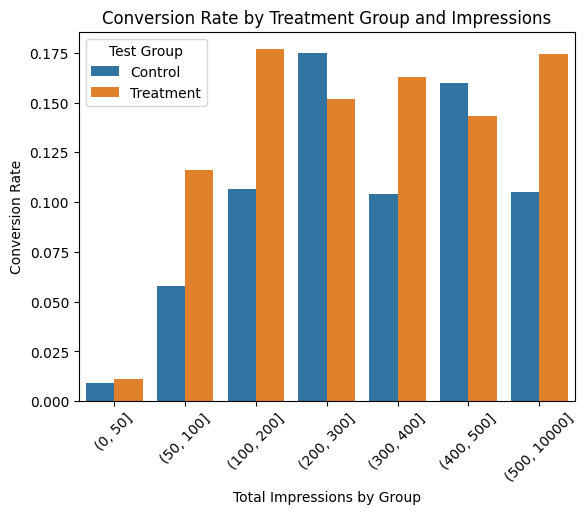

In [46]:
import matplotlib.pyplot as plt

sns.barplot(x = 'group_tot_impr', y = 'converted', data = ads_data, hue = 'test', ci = None)

plt.title('Conversion Rate by Treatment Group and Impressions')
plt.xlabel('Total Impressions by Group')
plt.xticks(rotation=45)
plt.ylabel('Conversion Rate')
plt.legend(title='Test Group', labels=['Control', 'Treatment'])

plt.show()

#### 3.b Based on the above figure, can we say that more impressions cause more conversions? (No more than 2 sentences)

No, we cannot say that more impressions cause more conversions, as there is a possibility that other factors, such as the timing, the reached audience, or the type of content, could have influenced the conversions.

### 4 Calculate the power of this experiment.

#### 4.a Calculate Cohen's D without using `pg.ttest`. Cohen's D, in this case, is the estimated average treatment effect on conversion divided by the standard deviation of conversion.

In [47]:
sd = ads_data['converted'].std()
cohen_d = ate / sd

print(f"The Cohen's D is {round(cohen_d, 2)}.")

The Cohen's D is 0.05.


#### 4.b Use the `power_ttest2n` function in `pingouin` to calculate the statistical power of the experiment.

In [48]:
power = pg.power_ttest2n(d=cohen_d,
                      nx=len(treated_sample), ny=len(control_sample),
                      alpha=0.05, alternative = 'two-sided')

print(f"The statistical power of the experiment is {round(power, 2)}.")

The statistical power of the experiment is 1.0.


#### 4.c What would the power be instead if the true effect had a cohen's D of .01?

In [51]:
cohen_d_new = 0.01

power = pg.power_ttest2n(d=cohen_d_new,
                      nx=len(treated_sample), ny=len(control_sample),
                      alpha=0.05, alternative = 'two-sided')

print(f"The statistical power, if the true effect had a Cohen's D of 0.01, would be {round(power, 2)}.")

The statistical power, if the true effect had a Cohen's D of 0.01, would be 0.32.


#### 4.d What would the power be instead if the true effect had a cohen's of .01 and the sample was equally split between treatment and control?

In [52]:
cohen_d_new = 0.01
treat_control_split= len(ads_data) / 2

power = pg.power_ttest2n(d=cohen_d_new,
                      nx=treat_control_split, ny=treat_control_split,
                      alpha=0.05, alternative = 'two-sided')

print(f"The statistical power, if the true effect had a Cohen's D of 0.01 and the sample was equally split, would be {round(power, 2)}.")

The statistical power, if the true effect had a Cohen's D of 0.01 and the sample was equally split, would be 0.97.


### 5. Case Discussion in Class
Please write what you would discuss in your presentation to TaskaBella. Your answer should be one paragraph and the paragraph should be five or fewer sentences. Be prepared to discuss in class. Think about what is the most important thing to say to TaskaBella.
No additional analysis is needed to answer this question.

In my presentation to TaskaBella, I would focus on the key takeaway that the campaign had a statistically significant impact on increasing purchases. The analysis that we have done shows that the difference in conversion rates between the treatment and control groups was significant, with a p-value far below the 0.05 threshold. This shows that the observed difference is unlikely due to random chance. While the effect size was small, the high statistical power of the test suggests that the result is reliable.

### How long did this problem set take you in hours? How did you find the level of difficulty?


The assignment took me 3-4 hours to finish, and the level of difficulty was hard.